# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.576210,False,2.419845
1,0.133613,False,-0.119371
2,0.854064,True,6.609971
3,-1.189485,False,-1.408508
4,-1.707458,False,-5.632720
...,...,...,...
995,0.036966,True,5.402195
996,-1.345899,True,2.877538
997,-1.236671,False,-5.219540
998,-0.107905,False,-0.451550


<AxesSubplot: xlabel='v0'>

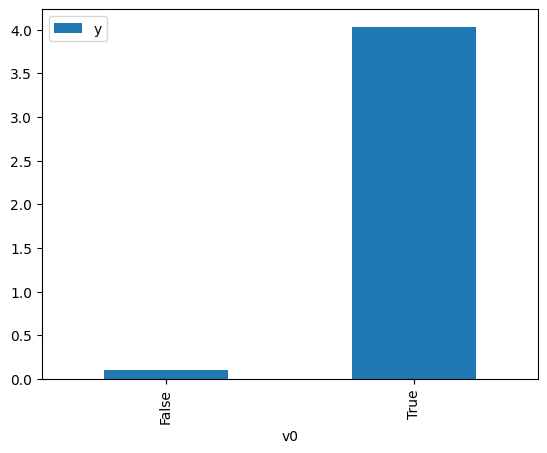

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

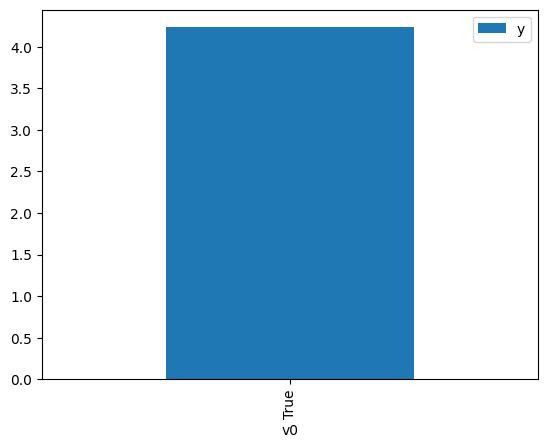

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.332031,False,-1.187925,0.637270,1.569193
1,-1.440073,False,-4.109074,0.921201,1.085539
2,-1.947500,False,-7.338464,0.965334,1.035911
3,1.016643,False,2.354598,0.148895,6.716134
4,-0.430571,False,-3.046104,0.675262,1.480906
...,...,...,...,...,...
995,-1.212616,False,-3.111947,0.887926,1.126220
996,0.522923,False,3.026567,0.289295,3.456684
997,-0.095121,False,-0.788702,0.539497,1.853580
998,0.952222,False,3.525197,0.163405,6.119746


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.308809,True,2.045846,0.096716,10.339564
1,1.076753,True,7.648613,0.863669,1.157851
2,0.195572,True,5.957500,0.583923,1.712556
3,0.619369,True,5.917144,0.743412,1.345149
4,0.865930,True,6.541439,0.815403,1.226388
...,...,...,...,...,...
995,0.663905,True,8.644763,0.757671,1.319834
996,-0.218632,True,6.073562,0.408644,2.447119
997,0.803091,True,7.263446,0.798673,1.252076
998,-1.388695,True,2.794118,0.085419,11.707027


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.331e+04
Date:                Tue, 14 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:04:31   Log-Likelihood:                         -1403.2
No. Observations:                1000   AIC:                                      2810.
Df Residuals:                     998   BIC:                                      2820.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8369      0.033     85.599      0.000       2.772       2.902
x2             4.9947      0.048    103.616      0.000       4.900       5.089
==============================================================================
Omnibus:                        6.623   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                8.102
Skew:                           0.079   Prob(JB):                       0.0174
Kurtosis:                       3.412   Cond. No.                         1.66
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""